# RPZ Assignment: Maximum Likelihood, Maximum a Posteriori and Bayesian Estimates of Distribution Parameters

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

At the very beginning of the recognition labs, we assumed the class probability densities $p_{X|k}(x|k)$ and the a priori probabilities $p_K(k)$ to be known and we used them to find the optimal [Bayesian strategy](https://cw.fel.cvut.cz/wiki/courses/be5b33rpz/labs/02_bayes/start). Later, we looked at problems where the a priori probability is not known or does not exist and we constructed the optimal [minimax strategy](https://cw.fel.cvut.cz/wiki/courses/be5b33rpz/labs/03_minimax/start). Today, we face the problem of unknown probability density function $p_{X|k}(x|k)$ and we will be interested in its estimation.

In this lab we will assume that the density function is of a known functional form, characterized by several parameters, and we will be dealing with estimating these parameters. In particular, we will consider two cases:
  * the density is modelled by a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) -- the unknown parameters will be the mean and variance of the distribution
  * the density is modelled as a [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) -- the unknown parameters will be the probabilities of individual classes/categories
  
To estimate the parameters we will use a training set - a set of examples drawn randomly from the true distribution.

We will implement and evaluate three parameter estimation methods: Maximum likelihood (ML), Maximum a posteriori (MAP), and Bayesian inference.

The assignment has three parts. In the first one we will apply all the methods to the Normal distribution, in the second to the Categorical distribution and in the third part we will build a Bayes classifier using the estimated densities.

In [130]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
from scipy.stats import norm

import numpy.testing as testing
from plotting_functions import *

import mle_map_bayes as mmb

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Normal distribution

At first, we will use synthetic data to examine the basic properties of different estimates. Start by generating some i.i.d. data $X=\{x_1, \ldots, x_N\}$ from a unimodal Normal distribution with $\mu=0$ and $\sigma^2=1$, i.e. $x_i \sim \mathcal{N}(\mu, \sigma^2)$. For most demonstrations $N=50$ data points will be enough. But feel free to experiment with larger datasets.

In [131]:
# generate data
num_samples = 50
mu_true = 0
var_true = 1
sigma_true = np.sqrt(var_true)
x = mu_true + np.random.randn(num_samples) * sigma_true

### Maximum Likelihood Estimation (MLE)

As you know from the [lecture](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/lectures/pr_03_parameter_estimation_2016_10_17.pdf), MLE is the solution to the following problem:

$$
\mu_*, \sigma_* = {\rm argmax}_{\mu, \sigma} p(X| \mu, \sigma) = {\rm argmax}_{\mu, \sigma} \prod_{i=1}^N p(x_i| \mu, \sigma)\;,
$$ 

where the likelihood $p(x_i|\mu, \sigma)$ is the Normal density $p_{\mathcal{N}}(x_i|\mu, \sigma)$.

**Tasks**

1\. Start by deriving the maximum likelihood estimates of the Normal distribution parameters $\mu$ and $\sigma^2$. Use the formulas to complete the function `mu, var = mmb.estim_normal(x)` (where `mmb` refers to the `mle_map_bayes.py` file imported above). Try to derive the maximum likelihood estimation on a piece of paper - we won't grade it, but it is useful training for the coming tests.

In [132]:
# ML estimate (basic test)
mu_mle, var_mle = mmb.ml_estim_normal(np.array([1, 4, 6, 3, 4, 7]))

# check if the result is correct
testing.assert_almost_equal((mu_mle, var_mle), (4.166667, 3.80556), decimal=5)

# ML estimate (random data generated from true distribution)
x_t = mu_true + np.random.randn(10000) * sigma_true
mu_mle, var_mle = mmb.ml_estim_normal(x_t)

# check if the result is correct
# correct implementation should recover values close to the true parameters when there are enough samples, i.e. be asymptotically consistent
testing.assert_almost_equal( (mu_mle, var_mle), (mu_true, sigma_true**2), decimal=1)

mu_mle, var_mle = mmb.ml_estim_normal(x)

2\. Use the function `plot_likelihood` to plot the likelihood for a range of $\mu$ and $\sigma^2$ values. Mark the true and estimated values. Next, plot the true and estimated distributions in one graph. Save the figure as `mle_normal.png`.

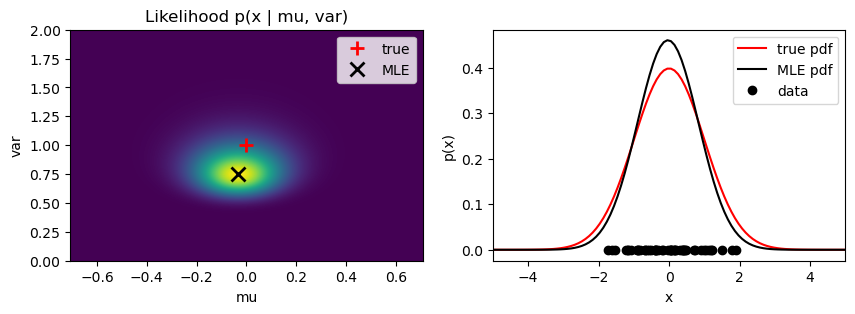

In [133]:
# plot the likelihood
# NOTICE: this works only for small num_samples (<=500), otherwise one gets zero everywhere due to numerical errors!
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
span_x = sigma_true * 5 / (num_samples**0.5) # kind of confidence interval
plot_likelihood(x, mu_true-span_x, mu_true + span_x, 0, sigma_true**2*2)
plt.plot([mu_true], [var_true], 'r+', markeredgewidth=2, markersize=10)
plt.plot([mu_mle], [var_mle], 'kx', markeredgewidth=2, markersize=10)
plt.legend(['true', 'MLE'])

# plot the estimated and true distributions
plt.subplot(1, 2, 2)
span_x = sigma_true * 5
z = np.linspace(mu_true - span_x, mu_true + span_x, 100)
p_true = norm.pdf(z, mu_true, sigma_true)
p_mle = norm.pdf(z, mu_mle, np.sqrt(var_mle))
plt.plot(z, p_true, 'r-')
plt.plot(z, p_mle, 'k-')
plt.plot(x, [-0.001] * x.size, 'ko')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.xlim([mu_true - span_x, mu_true + span_x])
plt.legend(['true pdf', 'MLE pdf', 'data'])
plt.savefig('mle_normal.png')

3\. Try to generate the data repeatedly while re-drawing the plots above. Observe the variations in the estimate. After seeing this, how much would you trust an ML estimate? Did you know that MLE is probably the most frequently used parameter estimation technique?

4\. A common way to avoid imprecise ML estimates is to increase the number of data points. Try to plot the true and estimated distributions with increasing number of samples. Save the figure as `mle_normal_varying_dataset_size.png`.

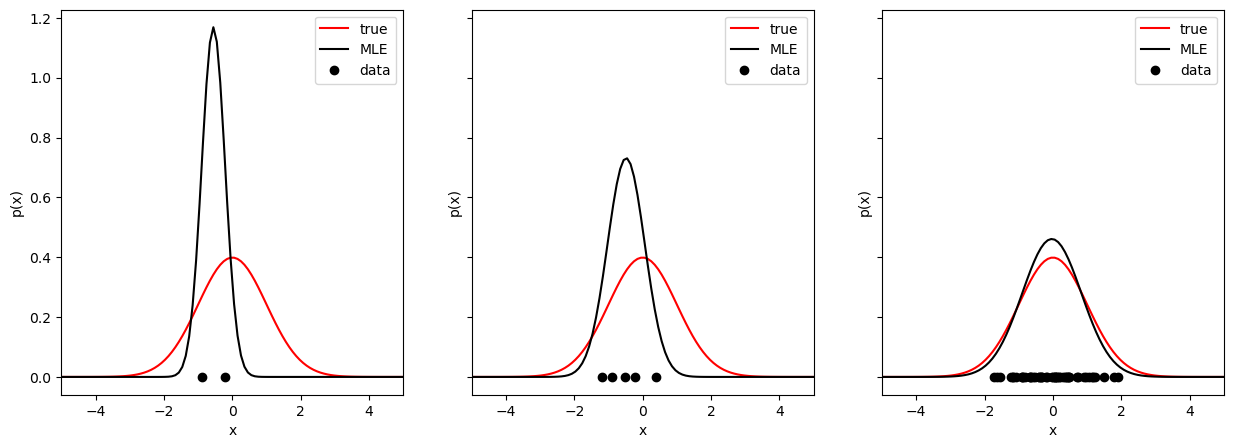

In [134]:
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(15, 5))

span_x = sigma_true * 5
z = np.linspace(mu_true - span_x, mu_true + span_x, 100)
p_true = norm.pdf(z, mu_true, sigma_true)

for (plot_pos, num) in zip((0, 1, 2), (2, 5, 50)):
    data = x[:num]
    mu_mle_part, var_mle_part = mmb.ml_estim_normal(data)
    
    # plot the estimated and true distributions
    plt.sca(axes[plot_pos])
    p_mle = norm.pdf(z, mu_mle_part, np.sqrt(var_mle_part))
    plt.plot(z, p_true, 'r-', label='true')
    plt.plot(z, p_mle, 'k-', label='MLE')
    plt.plot(data, [-0.001] * data.size, 'ko', label='data')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.xlim([mu_true - span_x, mu_true + span_x])
    plt.legend()

plt.savefig('mle_normal_varying_dataset_size.png')

### Maximum a Posteriori Estimation

As you know from the [lecture](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/lectures/pr_03_parameter_estimation_2016_10_17.pdf), in the MAP estimation the parameters are found by maximizing the a posteriori probability:

$$
\theta_* = {\rm argmax}_{\theta} p(\theta | X) = {\rm argmax}_{\theta} p(X| \theta) p(\theta)
$$

The advantage is that we can specify our prior knowledge about the true values of the parameters in the form of the prior distribution $p(\theta)$ and keep the estimate closer to it when not enough samples are available.

It was argued in the lecture that in order to obtain a close-form expression for _a posteriori probability_, one should use a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). In the lecture we were estimating only the mean ($\theta = \mu$) while $\sigma^2$ was assumed to be known. In this case a Normal distribution prior is conjugate, and finding MAP was simple. In the general case we consider in this lab we want to estimate mean and variance, i.e. $\theta = (\mu, \sigma^2)$. Fortunately, even in this case there exists a conjugate prior. Out of several [possible choices](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf) we will use [Normal Inverse Gamma distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution):

$$
p(\mu, \sigma^2) = {\rm NIG}(\mu, \sigma^2 | \mu_0, \nu, \alpha, \beta) = \frac{\sqrt{\nu}}{\sigma \sqrt{2\pi}} \frac{\beta^\alpha}{\Gamma(\alpha)} \left(\frac{1}{\sigma^2}\right)^{\alpha+1} \exp\left[-\frac{2\beta + \nu(\mu_0 - \mu)^2}{2\sigma^2}\right],
$$

where $\mu_0, \nu, \alpha$ and $\beta$ are the distribution parameters and $\Gamma(\cdot)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function) which is implemented in `scipy.special.gamma`.

A consequence of this choice, which we will explore in more detail in the next section on Bayesian inference, is that the a posteriori probability is again NIG, just with different parameters.

It is interesting to get the intuition behind the prior parameters. One can think of them as if before any data has been seen, the mean $\mu$ was estimated from $\nu$ observations with sample mean $\mu_{0}$ and the variance $\sigma^2$ was estimated from $2\alpha$ observations with sample mean $\mu_{0}$ and sum of [squared deviations](https://en.wikipedia.org/wiki/Squared_deviations) $2\beta$.

Alternatively, we may be interested in providing a prior values for $\mu$ and $\sigma^2$ (denoted $\mu_{my}, \sigma_{my}^2$) and then control the shape of the distribution around this peak. In this case, we set $\mu_0 = \mu_{my}$ and the parameters $\alpha$ and $\beta$ are linked by $\beta = \sigma_{my}^2 * (\alpha + 1.5)$, while $\nu$ stays a free parameter (this comes from [the equation of the mode of the NIG distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution)). So, using this parametrization we would specify e.g. $\mu_{my}, \sigma_{my}^2, \alpha$ and $\nu$ instead of the original four parameters.

The prior pdf is implemented in `norm_inv_gamma_pdf(mu, var, mu0, nu, alpha, beta)`. Go and check the implementation matches the above formulas.


**Tasks:**

1\. Plot the distribution using the provided `plot_prior` function together with its mode \[`mu_prior`, `var_prior`\].

In [135]:
# MAP prior settings
mu0 = 0
nu = 50
alpha = 25
beta = 26.5

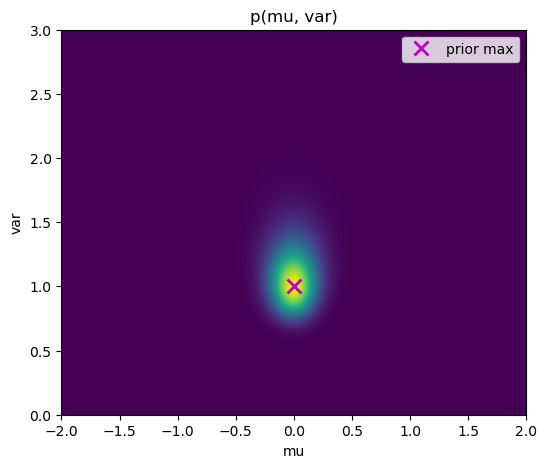

In [136]:
# the values of the peak of the prior distribution
mu_prior = 0
var_prior = 1

# plot the prior
plot_margin = 2
plt.figure(figsize=(6, 5))
prior_grid = plot_prior(mu0, nu, alpha, beta, mu0 - plot_margin, mu0 + plot_margin, 0, 3)

plt.plot([mu_prior], [var_prior], 'mx', markeredgewidth=2, markersize=10)
plt.legend(['prior max'])
plt.savefig('map_prior_normal.png')

2\. Experiment with different settings of $\mu_0, \nu, \alpha, \beta$ to get the feeling for how each of the parameters influences the prior. You will need this understanding later when we will be building a classifier using the MAP estimate.

3\. Show that the MAP estimate of the parameters $\mu$ and $\sigma^2$ with the normal inverse gamma prior is
$$
\mu_* = \frac{\nu\mu_0 + \sum_{i=1}^N x_i}{N + \nu}
$$
$$
\sigma_*^2 = \frac{2\beta + \nu(\mu_0 - \mu_*)^2 + \sum_{i=1}^N (x_i - \mu_*)^2}{N + 3 + 2\alpha}
$$ 
Submit a photo of handwritten derivation notes in `map_normal_derivation.jpg`

4\. Implement the `mmb.map_estim_normal` function which returns the MAP estimate of the parameters given the data and the prior probability parameters.

In [137]:
# MAP estimate
mu_map, var_map = mmb.map_estim_normal(np.array([2, 7, 3, 5, 1, 0]), mu0=0.0, nu=5.0, alpha=1.0, beta=2.5)
testing.assert_almost_equal((mu_map, var_map), (1.636364, 5.776860), decimal=5)

x_t = mu_true + np.random.randn(10000) * sigma_true
mu_map, var_map = mmb.map_estim_normal(x_t, mu0, nu, alpha, beta)
# correct implementation should recover values close to the true parameters when there are enough samples, i.e. be asymptotically consistent
testing.assert_almost_equal((mu_map, var_map), (mu_true, sigma_true**2), decimal=1)

mu_map, var_map = mmb.map_estim_normal(x, mu0, nu, alpha, beta)

5\. Plot the likelihood, prior and the MAP objective $p(X| \theta) p(\theta)$ next to each other, together with the MLE and MAP estimates and the prior maximum. Save the figure as `mle_map_prior_comparison_normal.png`
Notice that MAP objective is **not** a distribution as it does not integrate to one because we omitted the evidence $p(X)$!

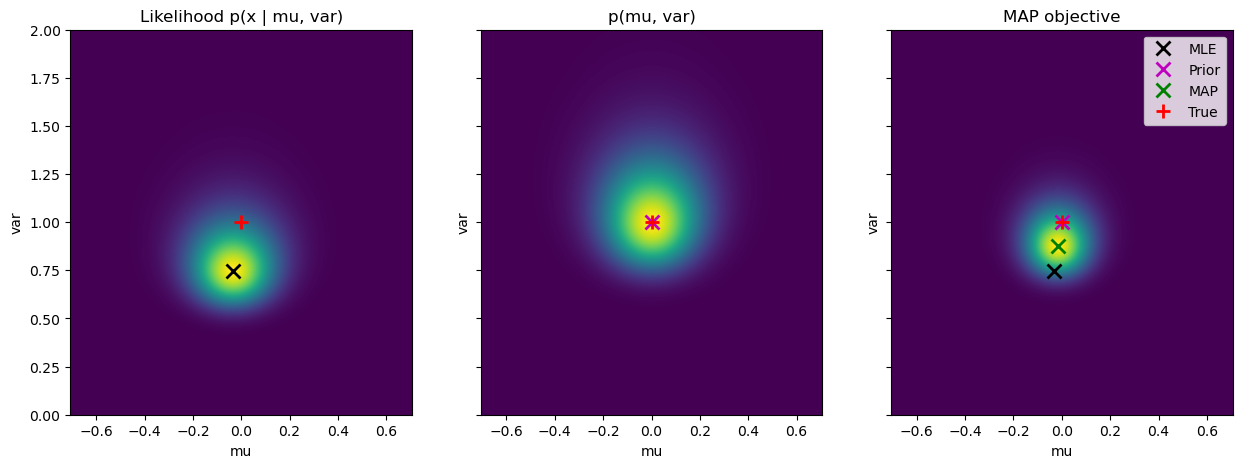

In [138]:
# plot the likelihood, prior and MAP objective together with the MLE and MAP estimates and the prior maximum.

span_x = sigma_true * 5 / (num_samples**0.5)  # kind of confidence interval
mu_min = min(mu_true - span_x, mu_mle)
mu_max = max(mu_true + span_x, mu_mle)
var_min = 0
var_max = sigma_true**2*2

fig, axes = plt.subplots(1, 3, sharey='row', figsize=(15, 5))
plt.sca(axes[0])
plot_likelihood(x, mu_min, mu_max, var_min, var_max)
plt.plot([mu_mle], [var_mle], 'kx', markeredgewidth=2, markersize=10, label='MLE')
plt.plot([mu_true], [var_true], 'r+', markeredgewidth=2, markersize=10, label='True')

plt.sca(axes[1])
plot_prior(mu0, nu, alpha, beta, mu_min, mu_max, var_min, var_max)
plt.plot([mu_prior], [var_prior], 'mx', markeredgewidth=2, markersize=10, label='Prior')
plt.plot([mu_true], [var_true], 'r+', markeredgewidth=2, markersize=10, label='True')

# The following plot is NOT a probability distribution!!! It is not normalised to sum up to one!
plt.sca(axes[2])
plot_MAP_objective(x, mu0, nu, alpha, beta, mu_min, mu_max, var_min, var_max)
plt.plot([mu_mle], [var_mle], 'kx', markeredgewidth=2, markersize=10, label='MLE')
plt.plot([mu_prior], [var_prior], 'mx', markeredgewidth=2, markersize=10, label='Prior')
plt.plot([mu_map], [var_map], 'gx', markeredgewidth=2, markersize=10, label='MAP')
plt.plot([mu_true], [var_true], 'r+', markeredgewidth=2, markersize=10, label='True')
plt.savefig('mle_map_prior_comparison_normal.png')
plt.legend()

6\. Examine the behaviour of the MAP estimate compared with the ML estimate and the prior. Experiment with
  * repeatedly sampling the dataset and observing the variations in the estimate
  * changing the prior parameters to see their effect on the estimate

7\. To explore the effect of the prior, plot the MLE and MAP estimates for different dataset sizes (e.g. 1, 5, 50). Plot the MAP objective with the estimates and prior indicated. Plot also the estimated distributions for each dataset size. You should see how the prior becomes more dominant for fewer data samples.
Notice that for a single data sample $X = \{x_1\}$ we do not plot the MLE solution. It would actually be $\sigma^2=0$ and $\mu=x_1$, so we would get an infinitely thin and infinitely tall normal distribution centred on the data point. This is of course not a realistic estimate. Save the figure as `mle_map_normal_dataset_sizes.png`

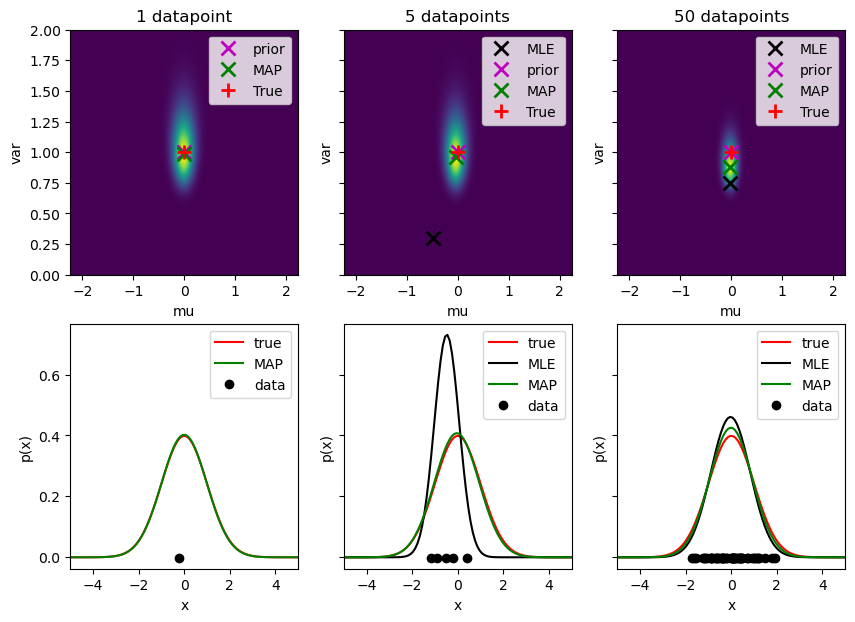

In [139]:
# Plot the MLE and MAP estimates for different dataset sizes (e.g. 1, 5, 50):
#   - plot the MAP objective with the estimates and prior indicated,
#   - plot also the estimated distributions for each dataset size.

span_x = sigma_true * 5 / (5**0.5)  # kind of confidence interval
mu_min = min(mu_true - span_x, mu_mle_part)
mu_max = max(mu_true + span_x, mu_mle_part)
var_min = 0
var_max = sigma_true**2*2

fig, axes = plt.subplots(2, 3, sharey='row', figsize=(10, 7))
for (plot_pos, num) in zip((0, 1, 2), (1, 5, 50)):
    data = x[:num]
    mu_map_part, var_map_part = mmb.map_estim_normal(data, mu0=mu0, nu=nu, alpha=alpha, beta=beta)
    mu_mle_part, var_mle_part = mmb.ml_estim_normal(data)
    
    plt.sca(axes[0, plot_pos])
    plot_MAP_objective(data, mu0, nu, alpha, beta, mu_min, mu_max, var_min, var_max)
    
    if num > 1:
        plt.plot([mu_mle_part], [var_mle_part], 'kx', markeredgewidth=2, markersize=10, label='MLE')
    plt.plot([mu_prior], [var_prior], 'mx', markeredgewidth=2, markersize=10, label='prior')
    plt.plot([mu_map_part], [var_map_part], 'gx', markeredgewidth=2, markersize=10, label='MAP')
    plt.plot([mu_true], [var_true], 'r+', markeredgewidth=2, markersize=10, label='True')
    plt.xlabel('mu')
    plt.ylabel('var')
    plt.legend()
    plt.title('{:d} datapoint{:s}'.format(num, '' if num == 1 else 's'))
    
    # plot the estimated and true distributions
    plt.sca(axes[1, plot_pos])
    span_x = sigma_true * 5
    z = np.linspace(mu_true - span_x, mu_true + span_x, 100)
    p_true = norm.pdf(z, mu_true, sigma_true)
    if var_mle_part > 0:
        p_mle = norm.pdf(z, mu_mle_part, np.sqrt(var_mle_part))
    p_map = norm.pdf(z, mu_map_part, np.sqrt(var_map_part))
    plt.plot(z, p_true, 'r-', label='true')
    if var_mle_part > 0:
        plt.plot(z, p_mle, 'k-', label='MLE')
    plt.plot(z, p_map, 'g-', label='MAP')
    plt.plot(data, [-0.001] * data.size, 'ko', label='data')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.xlim([mu_true - span_x, mu_true + span_x])
    plt.legend()
    
plt.savefig('mle_map_normal_dataset_sizes.png')

### Bayesian Inference

In the Bayesian Inference, we are interested in computing a posteriori distribution $p(\mu, \sigma^2 | X)$ over possible parameter values. We use the Bayes' rule:

$$
\begin{align*}
p(\mu, \sigma^2 | X, \mu_0, \nu, \alpha, \beta) &= \frac{\prod_{i=1}^N p(x_i|\mu, \sigma^2) p(\mu, \sigma^2)}{p(X)} \\
&=\frac{\prod_{i=1}^N \mathcal{N}(x_i|\mu, \sigma^2) {\rm NIG}(\mu, \sigma^2 | \mu_0, \nu, \alpha, \beta)}{p(X)} \\
&= \frac{\kappa {\rm NIG}(\mu, \sigma^2 | \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta})}{p(X)},
\end{align*}
$$
where the conjugate relationship between the likelihood and prior has been used and $\kappa$ is the associated normalization constant. The parameters of the new Normal Inverse Gamma distribution [can be shown](https://en.wikipedia.org/wiki/Conjugate_prior) to be

$$
\begin{align*}
\tilde{\alpha} = \alpha + N/2; \qquad \tilde{\nu} = \nu + N; \qquad \tilde{\mu}_0 = \frac{\nu \mu_0 + \sum_i x_i}{\nu + N}; \\
\tilde{\beta} = \beta + \frac{\sum_i x_i^2}{2} + \frac{\nu \mu_0^2}{2} - \frac{(\nu \mu_0 + \sum_i x_i)^2}{2(\nu + N)}.
\end{align*}
$$

Notice further, that the a posteriori is a distribution, i.e. it integrates to one. Since NIG on the right hand side already integrates to 1, it must be that $\kappa = p(X)$. So, thanks to the conjugacy of the prior, we arrive at a close-form solution to the a posteriori distribution:

$$
p(\mu, \sigma^2 | X, \mu_0, \nu, \alpha, \beta) = {\rm NIG}(\mu, \sigma^2 | \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta})
$$

**Tasks**

1\. Implement the above formulas in `mmb.bayes_posterior_params_normal`.

In [140]:
NIG_params = mmb.bayes_posterior_params_normal(np.array((0.5, 0.6)), 0.5, 6.3, 0.9, 2.1)
testing.assert_almost_equal(NIG_params, (0.5120481927710843, 8.3, 1.9, 2.1043975903614465), decimal=5)

 2\. Use the function `plot_posterior_normal` to plot the a posteriori probability over $\mu$ and $\sigma^2$ values. Mark the MLE, MAP and maximum a priori solutions. Save the figure as `bayes_posterior_normal.png`.

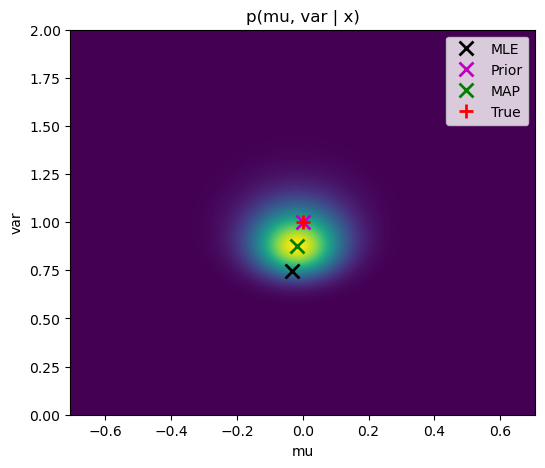

In [141]:
# plot the posterior probability and mark the MLE, MAP and maximum prior solutions

# assumes the same data and parameters as for MAP estimate
# assumes the MLE and MAP estimates are already computed

span_x = sigma_true * 5 / (num_samples**0.5)  # kind of confidence interval
mu_min = min(mu_true - span_x, mu_mle_part)
mu_max = max(mu_true + span_x, mu_mle_part)
var_min = 0
var_max = sigma_true**2*2

plt.figure(figsize=(6, 5))
prior_grid = plot_posterior_normal(x, mu0, nu, alpha, beta, mu_min, mu_max, var_min, var_max)
plt.plot([mu_mle], [var_mle], 'kx', markeredgewidth=2, markersize=10, label = 'MLE')
plt.plot([mu_prior], [var_prior], 'mx', markeredgewidth=2, markersize=10, label= 'Prior')
plt.plot([mu_map], [var_map], 'gx', markeredgewidth=2, markersize=10, label = 'MAP')
plt.plot([mu_true], [var_true], 'r+', markeredgewidth=2, markersize=10, label='True')
plt.legend()
plt.savefig('bayes_posterior_normal.png')

Notice that the graph looks exactly the same as for the MAP objective we created earlier. This is due to the normalization of the plots in matplotlib. As seen from the above, for the same prior, the MAP objective differs from the full Bayesian posterior only by a factor that does not depend on $(\mu, \sigma^2)$. The MAP objective does not integrate to 1, while the posterior does. The plotting function rescales the range automatically and hence the figures look the same.

One interpretation of this graph is that, truly, the most likely solution is the MAP estimate, but there are other possible solutions around it which are also rather likely. What we want to do is to take them into account when making the prediction of the estimated distribution.

#### Predictive density

In the Bayesian inference we do not take only the most probable estimate of $\mu$ and $\sigma^2$ and use it for evaluation of $p(x|\mu, \sigma^2)$, but we compute a weighted average of the predictions at a test point $x^*$ for each possible choice of parameters, where the weighting is given by the parameters posterior distribution. Formally, we compute $p(x^* | X, \mu_0, \nu, \alpha, \beta)$, the **predictive density** given the training data $X$, by integrating out the unknown model parameters from the joint distribution:
$$
\begin{align}
\notag p(x^* | X, \mu_0, \nu, \alpha, \beta) &= \int \int p(x^* | \mu, \sigma^2) p(\mu, \sigma^2 | X, \mu_0, \nu, \alpha, \beta) d\mu d\sigma \\
\notag &= \int \int \mathcal{N}(x^*|\mu, \sigma^2) {\rm NIG}(\mu, \sigma^2 | \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta}) d\mu d\sigma \\
&= \int \int \kappa(x^*, \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta}) {\rm NIG}(\mu, \sigma^2 | \breve{\mu}_0, \breve{\nu}, \breve{\alpha}, \breve{\beta}) d\mu d\sigma,
\end{align}
$$
where we used the conjugate relation for the second time (adopted from [Prince book](http://www.computervisionmodels.com/)) to merge the normal distribution $\mathcal{N}(x^*|\mu, \sigma^2)$ with NIG and obtain a new NIG with some parameters $(\breve{\mu}_0, \breve{\nu}, \breve{\alpha}, \breve{\beta})$ up to a constant coefficient $\kappa$ (not depending on the integration variables $\mu,\sigma$). This identity is achieved with 

$$
\begin{align*}
\breve{\alpha} = \tilde{\alpha} + 1/2 \qquad \breve{\nu} = \tilde{\nu} + 1 \\
\breve{\beta} = \frac{{x^*}^2}{2} + \tilde{\beta} + \frac{\tilde{\nu}\tilde{\mu}_0^2}{2} - \frac{(\tilde{\nu}\tilde{\mu}_0 + x^*)^2}{2(\tilde{\nu} + 1)}
\end{align*}
$$
and 
$$
\kappa(x^*, \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta}) = \frac{1}{\sqrt{2\pi}} \frac{\sqrt{\tilde{\nu}}\tilde{\beta}^{\tilde{\alpha}}}{\sqrt{\breve{\nu}}\breve{\beta}^{\breve{\alpha}}} \frac{\Gamma(\breve{\alpha})}{\Gamma(\tilde{\alpha})}.
$$.

Finally, the integral (1) is easy to compute since NIG integrates to one. We obtain:
$$
\begin{align*}
p(x^* | X, \mu_0, \nu, \alpha, \beta) &= \kappa(x^*, \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta}) \int \int {\rm NIG}(\mu, \sigma^2 | \breve{\mu}_0, \breve{\nu}, \breve{\alpha}, \breve{\beta}) d\mu d\sigma \\
&= \kappa(x^*, \tilde{\mu}_0, \tilde{\nu}, \tilde{\alpha}, \tilde{\beta}).
\end{align*}
$$

**Tasks**

1\. Implement the function `mmb.bayes_estim_pdf_normal` using the above equations.

In [142]:
points = np.linspace(0, 1, 10)
data = np.array([-0.15, -0.10, 0.41, 0.14, 1.45, 0.76, 0.12, 0.44, 0.33,
                 1.49, -0.20, 0.31, -0.85, -2.55, 0.65, 0.86, -0.74, 2.26, -1.45, 0.04])

predictive = mmb.bayes_estim_pdf_normal(points, data, -0.1, 4.0, 0.8, 2.1)

# basic correctness test
testing.assert_almost_equal(predictive, 
                            np.array([0.3526544 , 0.35471464, 0.35307831, 0.34780085, 0.33905956,
                                      0.32714294, 0.31243368, 0.2953868 , 0.27650482, 0.2563119 ]), decimal=3)

2\. Plot the estimated pdf for MLE, MAP and Bayes inference into one graph. Beware that the Bayes predictive density is **not** a Normal distribution anymore! Make plots for different dataset sizes. Save the figure as `mle_map_bayes_normal.png`

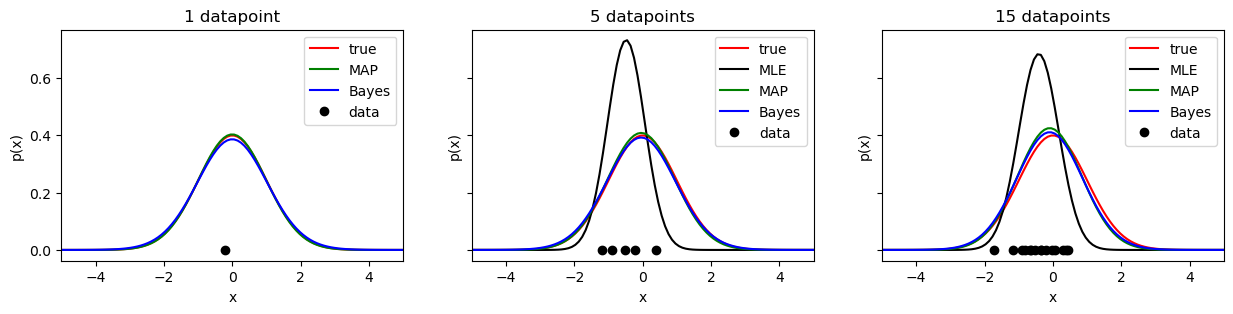

In [143]:
# predictive distribution and its comparison with MAP and MLE

fig, axes = plt.subplots(1, 3, sharey='row', figsize=(15,3))

span_x = sigma_true * 5
z = np.linspace(mu_true - span_x, mu_true + span_x, 100)
p_true = norm.pdf(z, mu_true, sigma_true)

for (plot_pos, num) in zip((0, 1, 2), (1, 5, 15)):
    data = x[:num]
    mu_map_part, var_map_part = mmb.map_estim_normal(data, mu0=mu0, nu=nu, alpha=alpha, beta=beta)
    mu_mle_part, var_mle_part = mmb.ml_estim_normal(data)
    
    # plot the estimated and true distributions
    if var_mle_part > 0:
        p_mle = norm.pdf(z, mu_mle_part, np.sqrt(var_mle_part))
    p_map = norm.pdf(z, mu_map_part, np.sqrt(var_map_part))
    p_bayes = mmb.bayes_estim_pdf_normal(z, data, mu0, nu, alpha, beta)
    
    plt.sca(axes[plot_pos])
    plt.plot(z, p_true, 'r-', label='true')
    if var_mle_part > 0:
        plt.plot(z, p_mle, 'k-', label='MLE')
    plt.plot(z, p_map, 'g-', label='MAP')
    plt.plot(z, p_bayes, 'b-', label='Bayes')
    plt.plot(data, [-0.001] * data.size, 'ko', label='data')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.legend()
    plt.xlim([mu_true - span_x, mu_true + span_x])
    plt.title('{:d} datapoint{:s}'.format(num, '' if num == 1 else 's'))

plt.savefig('mle_map_bayes_normal.png')

3\. Imagine that for some reason, part of your data is corrupted by errors/noise. Let's add a single out-of-distribution sample further from the distribution mean. Plot the likelihood and the distribution again. Plot the estimated distributions using this corrupted dataset. Save the figure as `noise.png`.

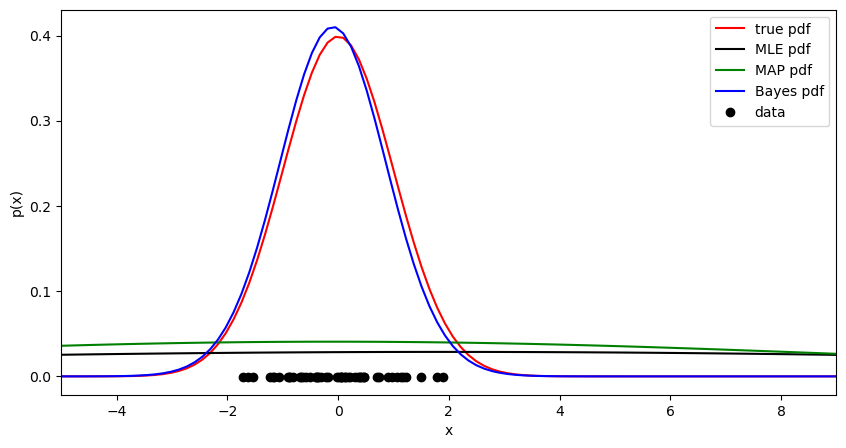

In [144]:
# add some outlier to the data (point not from the distribution)
x_noise = np.append(x, 100)
# plot the estimated and true distributions

plt.figure(figsize=(10, 5))
span_x = sigma_true * 5
z = np.linspace(mu_true - span_x, 9, 100)

mu_mle_noise, var_mle_noise = mmb.ml_estim_normal(x_noise)
mu_map_noise, var_map_noise = mmb.map_estim_normal(x_noise, mu0, nu, alpha, beta)

p_true = norm.pdf(z, mu_true, sigma_true)
p_mle = norm.pdf(z, mu_mle_noise, np.sqrt(var_mle_noise))
p_map = norm.pdf(z, mu_map_part, np.sqrt(var_map_noise))
p_bayes = mmb.bayes_estim_pdf_normal(z, data, mu0, nu, alpha, beta)
plt.plot(z, p_true, 'r-')
plt.plot(z, p_mle, 'k-')
plt.plot(z, p_map, 'g-')
plt.plot(z, p_bayes, 'b-')
plt.plot(x_noise, [-0.001] * x_noise.size, 'ko')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.xlim([mu_true - span_x, 9])
leg = plt.legend(['true pdf', 'MLE pdf', 'MAP pdf', 'Bayes pdf', 'data'])

plt.savefig('noise.png')

### Take-away summary
  * For a large data sample (compared to the number of parameters to be estimated, in our case 2) all techniques give approximately the same result and all of them converge to the true parameter values in the infinite sample size limit (cf. consistency of MLE). In this case MLE is the simplest choice.
  * For small data samples, MLE estimate could be rather random and biased. In our example, the MLE estimate of $\sigma^2$ underestimates the variance (biased), which can be observed as overconfident estimation of the density (density is too concentrated) for small sample sizes.
  * MAP allows to include a prior on the estimated parameters and can thus produce reasonable predictions even for a small data sample. It reduces the randomness of the estimated parameters compared to MLE and replaces degenerate solutions for too small sample sizes with some default solutions given by the prior.
  * MLE and MAP are sensitive to outliers, but it is not a problem of the MLE/MAP approach but a misspecification of the model (the observed data does not come from the Gaussian distribution). If we modelled the data as a mixture of a Gaussian distribution and some distribution of outliers, MLE for this model would be robust (but harder to compute). Other options are studied in *Robust Statistics*.
  * Bayesian estimates tend to be rather conservative (notice the heavier tails of the distribution) giving some probability to even data values not observed yet.
  * Bayesian inference is a more accurate technique, which is important for a small sample size, but the analytic solution can be computed in limited cases only. One then can look into approximations for Bayesian inference or try to increase data sample size and resort to basic MLE.
  * Both MAP and Bayesian approaches require specifying a prior. For more complex models it is not obvious what is a good prior. We will see later how a wrong prior influences a Bayesian *classifier* which uses a MAP estimate.

## Part 2: Categorical distribution

Next, let's look at estimating parameters of a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution). Suppose that our dataset $X=\{x_1, \ldots, x_N\}$ consists of points $x_i \in \{1, 2, \ldots, K\}$, like if we were throwing a biased dice or collecting preferences of $K$ presidential candidates. The categorical distribution is defined as

$$
p(x = k| p_1, \ldots, p_K) = p_k, \qquad \text{where} \quad \sum_{k=1}^K p_k = 1.
$$

For the ML and MAP we estimate the parameters $\{p_k\}_{k=1}^K$, for the Bayesian approach we compute a probability distribution over the parameters.


**Tasks**

1\. Start by generating data (e.g. 50 points) from a known categorical distribution with $K=6$. Make one of the class probabilities intentionally very small (e.g. 0.01) to be able to observe the effect of absent training samples for one bin.

In [145]:
# generate some data
num_classes = 6
num_samples = 50
pk_true = [0.198, 0.198, 0.198, 0.198, 0.198, 0.01]
np.random.seed(0)
counts = np.random.multinomial(num_samples, pk_true)
print(counts)


[10 11 10 10  9  0]


2\. Plot side-by-side the distribution itself and the histogram of the measured data (btw, categorical distribution is sometimes referred to as a 'normalized histogram'). Save the figure as `categorical_data.png`.

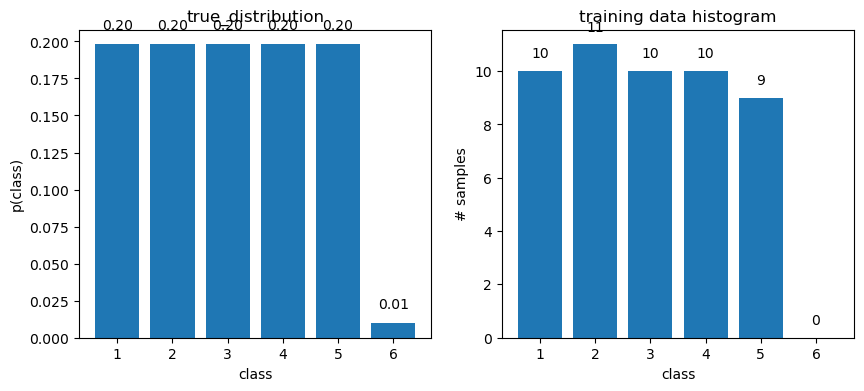

In [146]:
# visualise the data
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axes[0])
plot_categorical_distr(pk_true, 'true_distribution')

plt.sca(axes[1])
plot_categorical_hist(counts, 'training data histogram')

plt.savefig('categorical_data.png')

### MLE

**Tasks**

1\. Show that the maximum likelihood estimate of the parameters $p_k$ is

$$
\hat{p}_k = \frac{N_k}{\sum_{m=1}^K N_m},
$$
where $N_k$ is the number of measurements of the class $k$ (on a piece of paper, won't be checked). 

Use the [Lagrange multiplier method](https://en.wikipedia.org/wiki/Lagrange_multiplier) for the constraint $\sum_k p_k = 1$:
instead of maximizing the likelihood function $L(X | \theta) = L(X | p_1, \dots, p_K) = \prod\limits_{i=1}^N p(x_i | p_1, \dots, p_K)$, you should maximize 

$$L(X | \theta) + \lambda (1 - \sum_k p_k),$$

where the $\lambda$ is a new parameter called "Lagrange multiplier".
Maximize over all the parameters ($p_1, \dots, p_K, \lambda$) by setting derivatives equal to 0 and solving the resulting set of equations.
It is also easier to optimize the log-likelihood $l(X | \theta) = \log(L(X | \theta))$ rather than likelihood.

$$l(X | \theta) + \lambda (1 - \sum_k p_k)$$


2\. Complete the function `mmb.ml_estim_categorical` and use it to estimate the distribution parameters. Plot the estimated distribution. Save the figure as `mle_categorical.png`.

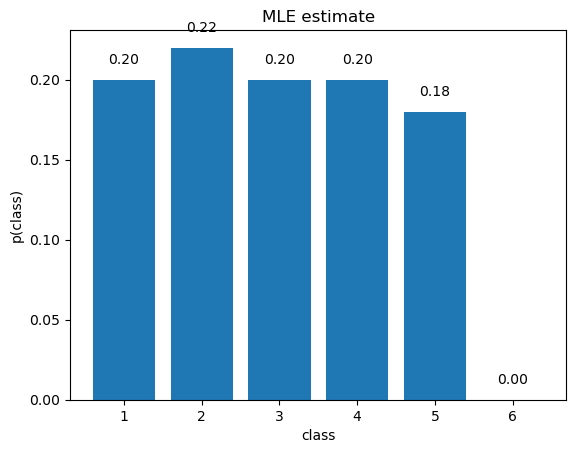

In [147]:
# compute the estimate
pc_mle = mmb.ml_estim_categorical(counts)

# visualise the estimate
plot_categorical_distr(pc_mle, 'MLE estimate')

plt.savefig('mle_categorical.png')

### MAP

As a prior needed for MAP estimation we choose the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) as it is conjugate to the categorical likelihood 

$$
{\rm Dir}(p_1, \ldots, p_K; \alpha_1, \ldots, \alpha_K) = \frac{1}{B(\alpha)} \prod_{k=1}^K p_k^{\alpha_k - 1},
$$
where the normalization constant $B(\alpha)$ is the Beta-function and $\alpha = (\alpha_1, \ldots, \alpha_K)$. It is implemented in `numpy.random.dirichlet`.

**Tasks**

1\. We start by examining the prior distribution for various parameter settings. Sample five random distributions from the prior and plot them side-by-side. Experiment with the parameters $\alpha$:
  * start with $\alpha_k = 1$ for all $k$
  * keep all the values the same, but increase their value
  * try to set one of $\alpha_k$'s significantly higher
  * try to set all $\alpha_k$ below 1 (this will not work with MAP estimate - you may get negative probability estimate)

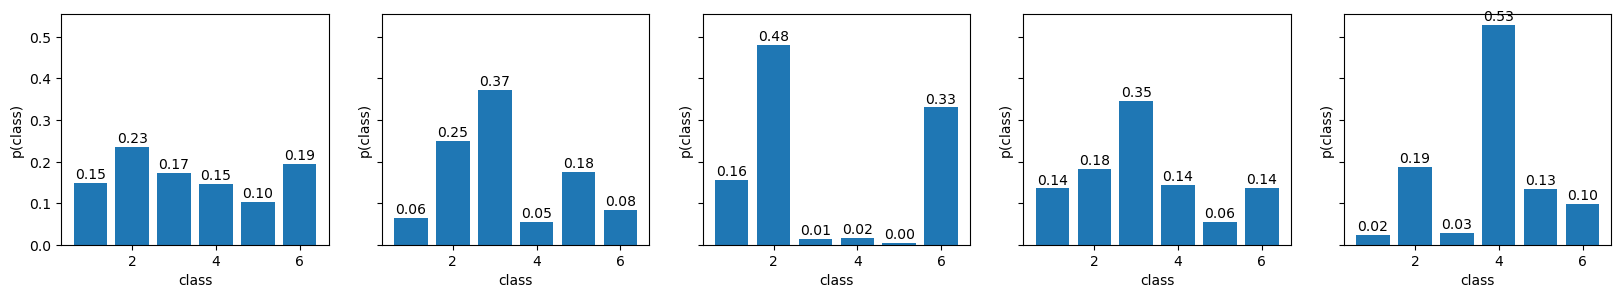

In [148]:
# random samples from the conjugate prior

alphas = np.ones(num_classes)
np.random.seed(0)
prior_samples = np.random.dirichlet(alphas, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 3), sharey='row')
for i in range(5):
    plt.sca(axes[i])
    plot_categorical_distr(prior_samples[i], '')

Thus, a fair dice would correspond to $\alpha_k \rightarrow \inf$ and when all $\alpha_k$'s are the same and greater than one, the distribution produces a fair dice on average. When the prior is uniform, i.e. when $\alpha_k = 1$ for all $k$, the MAP derivation reduces to the ML estimate.

Some more intuition for Dirichlet distribution as a conjugate prior is given in this [blog post](https://towardsdatascience.com/dirichlet-distribution-a82ab942a879).

2\. Show that the MAP estimate of the parameters $p_k$ is

$$
\hat{p}_k = \frac{N_k + \alpha_k - 1}{\sum_{m=1}^K (N_m + \alpha_m - 1)},
$$
where $N_k$ is the number of measurement of the class $k$.

**Hint:** The derivation is similar to the MLE estimate.

Submit a photo of handwritten derivation notes as `map_categorical_derivation.jpg`.


3\. Complete the function `mmb.map_estim_categorical` and use it to estimate the distribution parameters.

Plot the estimated distribution and save the figure as `map_categorical.png`.

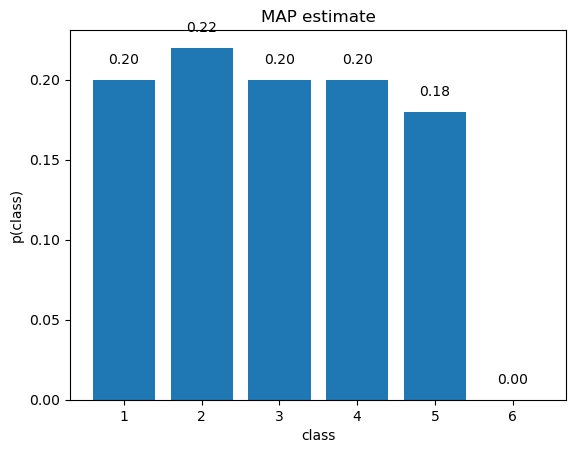

In [149]:
# compute the MAP estimate
pk_map = mmb.map_estim_categorical(counts, alphas)

plot_categorical_distr(pk_map, 'MAP estimate')
plt.savefig('map_categorical.png')

### Bayesian Estimate

In the Bayesian approach we calculate a posteriori probability over the parameters (derivations adopted from [Prince book](http://www.computervisionmodels.com/))

$$
\begin{align*}
p(p_1, \ldots, p_6| X) &= \frac{\prod_{i=1}^N p(x_i|p_1, \ldots, p_6) p(p_1, \ldots, p_6)}{p(X)} \\
&= \frac{\prod_{i=1}^N {\rm Cat}(x_i|p_1, \ldots, p_6) {\rm Dir}(p_1, \ldots, p_6; \alpha_1, \ldots, \alpha_6)}{p(X)} \\
&= \frac{\kappa(\alpha_{1},\ldots, \alpha_{6}, X) {\rm Dir}(p_1, \ldots, p_6; \tilde{\alpha}_1, \ldots, \tilde{\alpha}_6)}{p(X)} \\
&= {\rm Dir}(p_1, \ldots, p_6; \tilde{\alpha}_1, \ldots, \tilde{\alpha}_6),
\end{align*}
$$
where $\tilde{\alpha}_k = N_k + \alpha_k$ and where we have once again exploited the conjugate relationship between the likelihood and prior. And as before, the normalization constant $\kappa$ cancels out with the denominator in order to obtain a valid probability distribution.

The predictive density used in ML and MAP was simply the categorical distribution with the estimated parameters $\hat{p}_k$. In the Bayesian case, we compute a weighted average of the predictions for each possible parameter choice, where the weighting is given by the parameters posterior distribution.

$$
\begin{align*}
p(x^*|X) &= \int p(x^*|p_1, \ldots, p_6) p(p_1, \ldots, p_6| X) dp_{1\ldots 6} \\
&= \int {\rm Cat}(x^*|p_{1\ldots 6}) {\rm Dir}(p_{1\ldots 6}; \tilde{\alpha}_{1\ldots 6}) dp_{1\ldots 6} \\
&= \int \kappa(x^*, \tilde{\alpha}_{1\ldots 6}) {\rm Dir}(p_{1\ldots 6}; \breve{\alpha}_{1\ldots 6}) dp_{1\ldots 6} \\
&= \kappa(x^*, \tilde{\alpha}_{1\ldots 6}),
\end{align*}
$$
where 
$$
\kappa(x^*, \tilde{\alpha}_{1\ldots 6}) = \frac{N_k + \alpha_k}{\sum_{j=1}^6 (N_j + \alpha_j)}.
$$

**Tasks**

1\. Implement the `mmb.bayes_posterior_params_categorical` function.


2\. Sample five samples from the parameter posterior distribution and display them side-by-side. Compared with the samples from the prior, they should resemble better the data distribution. Save the figure as `bayes_posterior_categorical.png`.

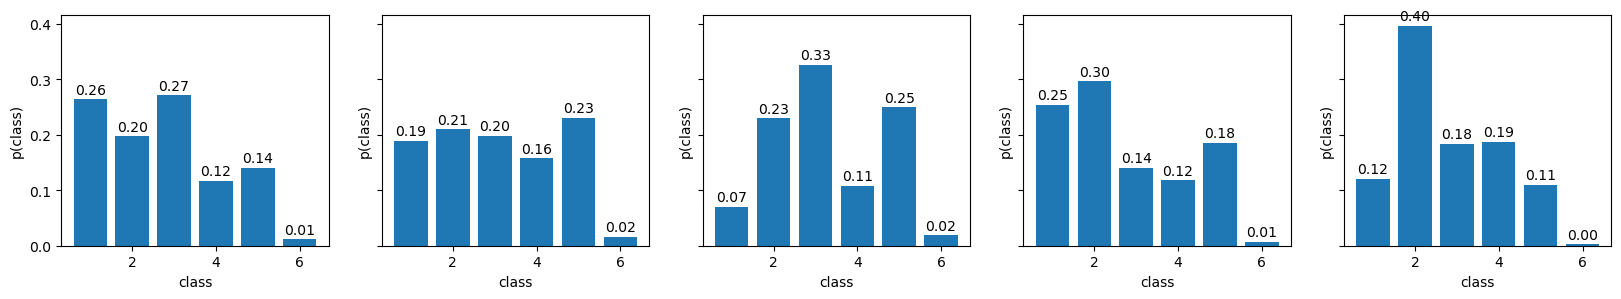

In [150]:
# compute the posterior
pc_posterior = mmb.bayes_posterior_params_categorical(counts, alphas)

# random samples from the posterior p(pc_posterior|counts)
np.random.seed(0)
posterior_samples = np.random.dirichlet(pc_posterior, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 3), sharey='row')
for i in range(5):
    plt.sca(axes[i])
    plot_categorical_distr(posterior_samples[i], '')
    
plt.savefig('bayes_posterior_categorical.png')

3\. Implement the function `mmb.bayes_estim_categorical` which returns the Bayesian estimate and plot the distribution. 
Plot the estimated distribution. Save the figure as `bayes_categorical.png`.

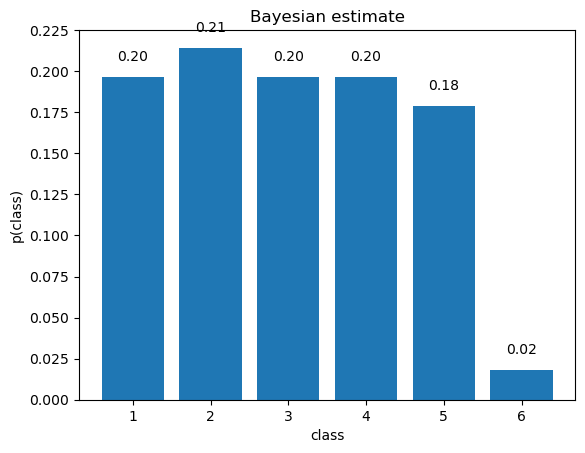

In [151]:
pc_bayes = mmb.bayes_estim_categorical(counts, alphas)

plot_categorical_distr(pc_bayes, 'Bayesian estimate')
plt.savefig('bayes_categorical.png')

4\. Experiment with different priors.

### Take-away summary
  * Notice that even with flat uninformative prior (i.e. when $\alpha_1 = \ldots = \alpha_6 = 1$), Bayesian approach tends to give non-zero probability to bins for which no data has been observed yet.
  * In contrast, in MAP estimate the flat prior resulted in the same result as in ML estimate.

## Part 3: Building a classifier

In this part we will use the MLE, MAP and Bayesian estimates for the Normal distribution to build a Bayes classifier as in the previous assignments. Feel free to reuse your code from the previous labs to finish this task. However, upload every function needed so that we can evaluate it automatically.

The task is again to distinguish the images of letters 'A' from images of 'C' using the `compute_measurement_lr_cont` measurement.

Spend some time specifying a meaningful prior for MAP and Bayesian estimates **for both classes**. The old values (0, 1) will no longer work here as the mean and variance of the data is different (in thousands)! It is recommended to plot the prior for a visual feedback for the parameters.


**Tasks**

1\. Implement the functions `mmb.mle_Bayes_classif`, `mmb.map_Bayes_classif` and `mmb.bayes_Bayes_classif`. Assume 0/1 loss function. The first two will use the strategy from the Bayes classification labs, whereas for the bayesian estimate the pdf is no longer a Normal distribution, so we have to use the inequality $p(A)p(x|A) > p(C)p(x|C)$ for deciding for the class. Compute the a priori probabilities as relative frequencies in the *training* dataset.

In [152]:
# load data
loaded_data = np.load("data_33rpz_mle_map_bayes.npz", allow_pickle=True)

alphabet = loaded_data["alphabet"]

tst = loaded_data["tst"].item()

trn_20 = loaded_data["trn_20"].item()
trn_200 = loaded_data["trn_200"].item()
trn_2000 = loaded_data["trn_2000"].item()

trn_sets = {'20': trn_20, '200': trn_200, '2000': trn_2000}

2\. Compute the classification error on the test set for all three methods.

In [153]:
contA = {'Mean': 124.2625,
         'Sigma': 1434.45420083}
contC = {'Mean': -2010.98,
         'Sigma': 558.42857106}

# classify the data using all three estimates

# select the training set
picked_set = '20' # your code probably won't work for '200' or '2000' due to numerical limitations
# feel free to search for the source of the numerical problems and come up with a workaround
# (it is doable relatively easily for '200')
trn_set = trn_sets[picked_set]

# computing LR feature vectors (training set)
x_train = mmb.compute_measurement_lr_cont(trn_set['images'])
labels_train = trn_set['labels']

# Splitting the training data into into classes
x_A = x_train[labels_train == 0]
x_C = x_train[labels_train == 1]

# NIG prior settings
mu0_A, nu_A, alpha_A, beta_A = contA['Mean'], 20, 10, 11.5 * contA['Sigma']**2
mu0_C, nu_C, alpha_C, beta_C = contC['Mean'], 20, 10, 11.5 * contC['Sigma']**2

x_test = mmb.compute_measurement_lr_cont(tst['images'])
q_mle, labels_mle, DA_mle, DC_mle = mmb.mle_Bayes_classif(x_test, x_A, x_C)
error_mle = mmb.classification_error(labels_mle, tst['labels'])
print('MLE classification error: {:.2f} %'.format(error_mle * 100))
testing.assert_almost_equal(error_mle, 0.075, decimal=4)

q_map, labels_map, DA_map, DC_map = mmb.map_Bayes_classif(x_test, 
                                                          x_A, x_C,
                                                          mu0_A, nu_A, alpha_A, beta_A, 
                                                          mu0_C, nu_C, alpha_C, beta_C)
error_map = mmb.classification_error(labels_map, tst['labels'])
print('MAP classification error: {:.2f} %'.format(error_map * 100))
assert error_map < 0.075, "We expect MAP to produce better classification error than MLE, but depending on your prior this may not hold"

labels_Bayes = mmb.bayes_Bayes_classif(x_test, x_A, x_C,
                                       mu0_A, nu_A, alpha_A, beta_A, 
                                       mu0_C, nu_C, alpha_C, beta_C)
error_bayes = mmb.classification_error(labels_Bayes, tst['labels'])
print('Bayes classification error: {:.2f} %'.format(error_bayes * 100))
assert error_bayes < 0.075, "We expect Bayesian predictive classifier to produce better classification error than MLE, but depending on your prior this may not hold"


MLE classification error: 7.50 %
MAP classification error: 7.00 %
Bayes classification error: 6.50 %


3\. Visualize the data through normalized histograms, plot the estimated probability densities and the estimated strategies all in one plot. Save the figure as `mle_map_bayes_Bayes_classifier.png`.

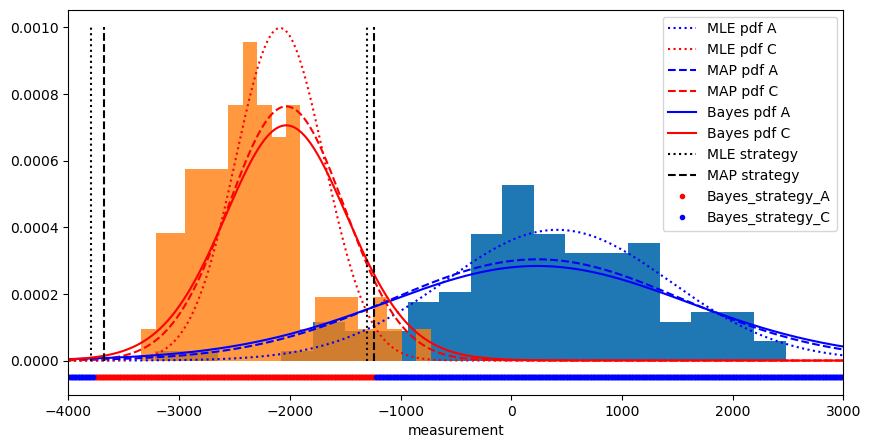

In [154]:
# visualise the estimates

plt.figure(figsize=(10, 5))
x_tst_all = mmb.compute_measurement_lr_cont(tst['images'])
x_A_tst = x_tst_all[tst['labels'] == 0]
x_C_tst = x_tst_all[tst['labels'] == 1]
plt.hist(x_A_tst, 20, density=True)
plt.hist(x_C_tst, 20, density=True, alpha=0.8)
z = np.linspace(-4000, 3000, 1000)

p_mle_A = norm.pdf(z, DA_mle['Mean'], DA_mle['Sigma'])
p_mle_C = norm.pdf(z, DC_mle['Mean'], DC_mle['Sigma'])
plt.plot(z, p_mle_A, 'b:', label='MLE pdf A')
plt.plot(z, p_mle_C, 'r:', label='MLE pdf C')

p_map_A = norm.pdf(z, DA_map['Mean'], DA_map['Sigma'])
p_map_C = norm.pdf(z, DC_map['Mean'], DC_map['Sigma'])
plt.plot(z, p_map_A, 'b--', label='MAP pdf A')
plt.plot(z, p_map_C, 'r--', label='MAP pdf C')

p_bayes_A = mmb.bayes_estim_pdf_normal(z, x_A, mu0_A, nu_A, alpha_A, beta_A)
p_bayes_C = mmb.bayes_estim_pdf_normal(z, x_C, mu0_C, nu_C, alpha_C, beta_C)
plt.plot(z, p_bayes_A, 'b-', label='Bayes pdf A')
plt.plot(z, p_bayes_C, 'r-', label='Bayes pdf C')

plt.plot([q_mle['t1'], q_mle['t1']], [0, 0.001], 'k:', label='MLE strategy')
plt.plot([q_mle['t2'], q_mle['t2']], [0, 0.001], 'k:', label=None)
plt.plot([q_map['t1'], q_map['t1']], [0, 0.001], 'k--', label='MAP strategy')
plt.plot([q_map['t2'], q_map['t2']], [0, 0.001], 'k--', label=None)

classif_bayes = mmb.bayes_Bayes_classif(z, x_A, x_C,
                                        mu0_A, nu_A, alpha_A, beta_A,
                                        mu0_C, nu_C, alpha_C, beta_C)
y_val = np.ones_like(z) * (-0.00005)
plt.plot(z[classif_bayes == 1], y_val[classif_bayes == 1], 'r.', label='Bayes_strategy_A')
plt.plot(z[classif_bayes == 0], y_val[classif_bayes == 0], 'b.', label='Bayes_strategy_C')

plt.xlim([-4000, 3000])
plt.legend()
plt.xlabel('measurement')
plt.savefig('mle_map_bayes_Bayes_classifier.png')

4\. Experiment with setting the MAP prior probability parameters in various ways to get the feeling for how they influence the final classification.

5\. Experiment with different training dataset sizes (20, 200, 2000 samples). Observe the influence of the prior parameters on the classification given different dataset sizes.

## Submission to the BRUTE Upload System

To fulfil this assignment, you need to submit these files (all packed in one ''.zip'' file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:

- `mle_map_bayes.ipynb` - a notebook for data initialization, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
- `mle_map_bayes.py` - file with the following methods implemented:
    - `ml_estim_normal` - function which computes a ML estimate of Normal distribution parameters
    - `ml_estim_categorical` - function which computes a ML estimate of Categorical distribution parameters
    - `map_estim_normal` - function which computes a MAP estimate of Normal distribution parameters
    - `map_estim_categorical` - function which computes a MAP estimate of Categorical distribution parameters
    - `bayes_posterior_params_normal` - function which computed the a posteriori distribution parameters using Bayesian inference for Normal distribution
    - `bayes_posterior_params_categorical` - function which computed the a posteriori distribution parameters using Bayesian inference for Categorical distribution
    - `bayes_estim_pdf_normal` - function which computes a Bayesian estimate for Normal distribution as a NIG probability density function
    - `bayes_estim_categorical` - function which computes a Bayesian estimate of Categorical distribution parameters
    - `mle_Bayes_classif` - function which classifies using ML estimate of normal distributions
    - `map_Bayes_classif` - function which classifies using MAP estimate of normal distributions
    - `bayes_Bayes_classif` - function which classifies using Bayes estimate of normal distributions
- `map_normal_derivation.jpg` and `map_categorical_derivation.jpg` - images of handwritten derivations
- `mle_normal.png`, `mle_normal_varying_dataset_size.png`, `map_prior_normal.png`, `mle_map_prior_comparison_normal.png`, `mle_map_normal_dataset_sizes.png`, `bayes_posterior_normal.png`, `mle_map_bayes_normal.png`, `noise.png`, `categorical_data.png`, `mle_categorical.png`, `map_categorical.png`, `bayes_posterior_categorical.png`, `bayes_categorical.png` and `mle_map_bayes_Bayes_classifier.png` - images specified in the assignment

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.

It is not possible to import your previously implemented functions from `bayes.py` in BRUTE, please copy all the necessary functions directly into `mle_map_bayes.py`. Sorry for the inconvenience.

You will gain **max 4 points by uploading your solution** (including the handwritten derivations) to the upload system. You will be awarded the **remaining 2 if your handwritten notes are correct** (we will inspect them manually). We will always make a note in BRUTE when your solution is checked. If you need a new attempt, please, contact directly your lab teaching assistant.

## References

[1] Simon J.D. Prince. Computer Vision: Models, Learning, and Inference. Cambridge University Press, 2012. http://www.computervisionmodels.com/